# Exercise 4.1: Filters in CNNs

Advanced Machine Learning for KCS

by Stefan Heinrich, Stella Grasshof, Laura Weihl
with material by Kevin Murphy

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

## Demonstration of some Filters as used in Convolutional Neural Networks

*Hint: We use pytorch for these practical examples. Read up about the concepts of tensor data structures and graph computation in the tutorials and the API that we have introduces last week, if needed!*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
# pyTorch, a powerful machine learning framework
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# Helper method
def tensor_to_image(data: torch.Tensor):
  img = plt.imshow(data.numpy())
  img.set_cmap('gray')
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])

### Convolution & filters

In [3]:
def conv2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) #create output size
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() #convolve
    return Y

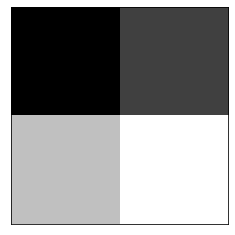

In [29]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
filtered = conv2d(X, K)

# plt.imshow(filtered.numpy(), cmap='gray')
tensor_to_image(filtered)

     0    1    2    3    4    5    6    7
0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
4  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
5  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 shape -> torch.Size([6, 8])


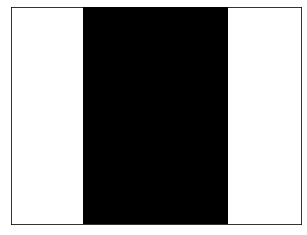

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
tensor_to_image(X)
print(pd.DataFrame(X.numpy()))
print(f" shape -> {X.shape}")

     0    1
0  1.0 -1.0
1  1.0 -1.0
 shape -> torch.Size([2, 2])


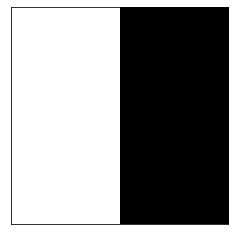

In [6]:
kernel = torch.tensor([[1.0, -1.0], [1.0, -1.0]])
tensor_to_image(kernel)
print(pd.DataFrame(kernel.numpy()))
print(f" shape -> {kernel.shape}")

     0    1    2    3    4    5    6
0  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
1  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
2  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
3  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
4  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
 shape -> torch.Size([5, 7])


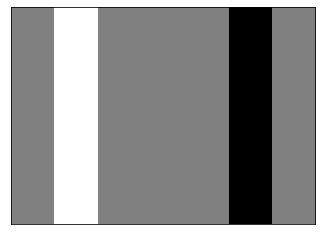

In [7]:
x_filtered = conv2d(X, kernel)
tensor_to_image(x_filtered)
print(pd.DataFrame(x_filtered.numpy()))
print(f" shape -> {x_filtered.shape}")

 shape -> torch.Size([300, 400])


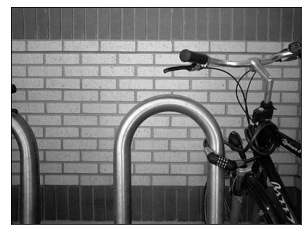

In [8]:
im = np.array(Image.open('bike.jpg').convert('L'))
im_tens = torch.Tensor(im)
tensor_to_image(im_tens)
print(f" shape -> {im_tens.shape}")


#### Apply our vertical and horizontal kernels and convolve them through the image.


In [9]:
horizontal_res = conv2d(im_tens, kernel)
vertical_res = conv2d(im_tens, kernel.t())

shape -> torch.Size([299, 399])


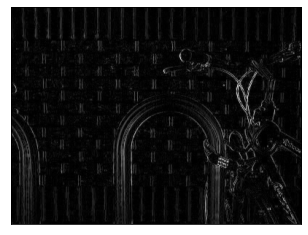

In [10]:
print(f"shape -> {vertical_res.shape}")
tensor_to_image(horizontal_res.abs())

shape -> torch.Size([299, 399])


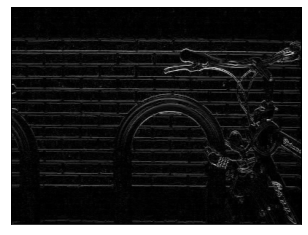

In [11]:
tensor_to_image(vertical_res.abs())
print(f"shape -> {vertical_res.shape}")

shape -> torch.Size([299, 399])


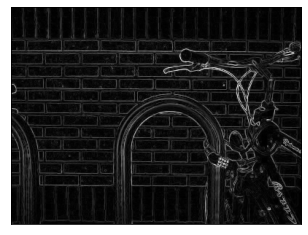

In [12]:
c = (horizontal_res ** 2 + vertical_res ** 2) ** 0.5
tensor_to_image(c)
print(f"shape -> {c.shape}")

In [13]:
sobel_hor = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_ver = sobel_hor.t()

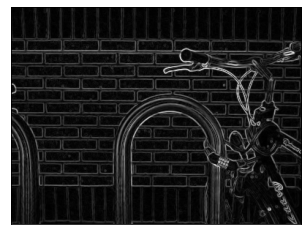

In [14]:
sob_engine_h = conv2d(im_tens, sobel_hor)
sob_engine_v = conv2d(im_tens, sobel_ver)

total_sobel_img = (sob_engine_h ** 2 + sob_engine_v ** 2) ** 0.5
tensor_to_image(total_sobel_img)

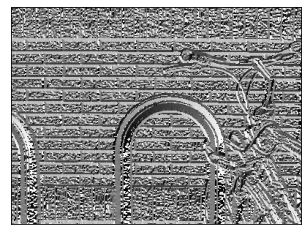

In [15]:
# Sobel operator gradient directions
total_sobel_grad = torch.atan2(sob_engine_v, sob_engine_h)
tensor_to_image(total_sobel_grad)

In [16]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        # Kernel values
        self.weight = nn.Parameter(torch.rand(kernel_size))
        # Bias
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return conv2d(x, self.weight) + self.bias

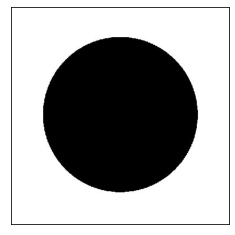

In [17]:
circle_im = torch.Tensor(np.array(Image.open('circle.jpg').convert('L')))
tensor_to_image(circle_im)

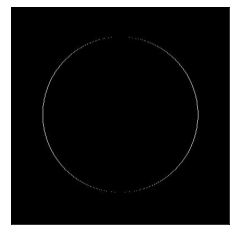

In [18]:
filtered_circle = conv2d(circle_im, kernel)
tensor_to_image(filtered_circle.abs())

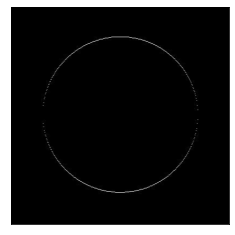

In [19]:
filtered_circle_t = conv2d(circle_im, kernel.t())
tensor_to_image(filtered_circle_t.abs())

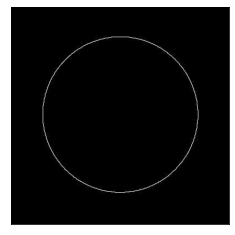

In [20]:
tensor_to_image((filtered_circle_t ** 2 + filtered_circle ** 2) ** 0.5)

In [21]:
conv_nn = Conv2D((2,2))

# Input image from the previous example
X = torch.ones((6, 8))
X[:, 2:6] = 0

# Predesigned kernel from the previous example
Y = conv2d(X, kernel)

lr = 3e-2  # Learning rate

for i in range(300):
    Y_hat = conv_nn(X)
    l = (Y_hat - Y)**2
    conv_nn.zero_grad()
    l.mean().backward()
    # Update the kernel
    conv_nn.weight.data[:] -= lr * conv_nn.weight.grad
    if (i + 1) % 20 == 0:
        print(f'batch {i + 1}, loss {l.mean():.3f}')

batch 20, loss 0.719
batch 40, loss 0.314
batch 60, loss 0.156
batch 80, loss 0.078
batch 100, loss 0.039
batch 120, loss 0.020
batch 140, loss 0.010
batch 160, loss 0.005
batch 180, loss 0.002
batch 200, loss 0.001
batch 220, loss 0.001
batch 240, loss 0.000
batch 260, loss 0.000
batch 280, loss 0.000
batch 300, loss 0.000


In [22]:
conv_nn.weight

Parameter containing:
tensor([[ 0.8170, -0.8330],
        [ 1.1716, -1.1556]], requires_grad=True)

### Padding

shape -> torch.Size([399, 400])


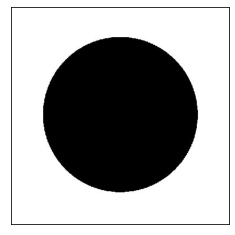

In [23]:
circle_im = torch.Tensor(np.array(Image.open('circle.jpg').convert('L')))
print(f"shape -> {circle_im.shape}")
tensor_to_image(circle_im)

shape -> torch.Size([401, 402])


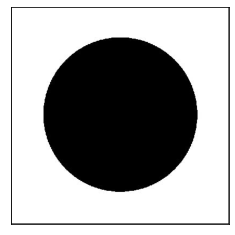

In [24]:
padded_circle_im = F.pad(circle_im, (1,1,1,1), value=1)
print(f"shape -> {padded_circle_im.shape}")
tensor_to_image(padded_circle_im)

shape -> torch.Size([399, 400])


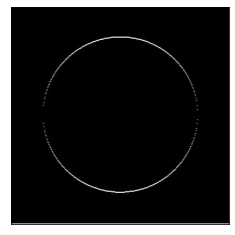

In [25]:
f_circle_im = conv2d(padded_circle_im, sobel_ver)
print(f"shape -> {f_circle_im.shape}")
tensor_to_image(f_circle_im.abs())